# Reinforcement  Learning

<a href="https://colab.research.google.com/github/riccardoberta/machine-learning/blob/master/XX_reinforcement_learning/reinforcement_learning.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Google Colab"/></a>

What if we need to tackle complex problems, such as detecting hundreds of types of objects in high-resolution images? We need to train a **deeper** ANN, perhaps with 10 layers or many more, each containing hundreds of neurons, linked by hundreds of thousands of connections. However, training a **Deep Deep Neural Network (DNN)** rise some problems:
- the gradients can grow smaller and smaller, or larger and larger, when flowing backward through the DNN during training, making lower layers very hard to train (***vanishing/explodin gradients***);
- we might not have enough training data for such a large network, or it might be too costly to label;
- training may be extremely slow;
- a model with millions of parameters would severely risk overfitting the training set.

In the following we will go through each of these problems and present techniques to solve them. 

1. [The Vanishing Exploding Gradients Problems](#The-Vanishing-Exploding-Gradients-Problems)
    - [Initialization strategies](#Initialization-strategies)
    - [Nonsaturating Activation Functions](#Nonsaturating-Activation-Functions)
    - [Batch Normalization](#Batch-Normalization)
    - [Gradient Clipping](#Gradient-Clipping)
2. [Transfer Learning](#Transfer-Learning)
3. [Faster Optimization](#Faster-Optimization)
    - [Momentum Optimization](#Momentum-Optimization)

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## The Vanishing Exploding Gradients Problems
The backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient along the way. Once the algorithm has computed the gradient of the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step.

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. We call this the **vanishing
gradients problem**. 

In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight update and the algorithm diverges. This is the **exploding gradients problem**, which
surfaces in recurrent neural networks. 

More generally, DNN suffer from **unstable gradients**.

The problem is due to  the combination of the logistic sigmoid activation function and the weight initialization technique (i.e., a normal distribution with a mean of 0 and a standard deviation of 1). 

It can be showed that with this combination, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This saturation is actually made worse by the fact that the logistic function has a mean of 0.5, not 0.

For a detailed matematical description, see the paper [Xavier Glorot and Yoshua Bengio, **Understanding the Difficulty of Training Deep Feedforward Neural Networks**, Proceedings of the 13th International Conference on Artificial Intelligence and Statistics (2010)](http://proceedings.mlr.press/v9/glorot10a.html)

Looking at the logistic activation function, we can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0:

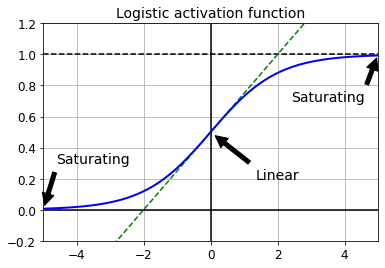

In [9]:
def logit(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(x, logit(x), "b-", linewidth=2)

props = dict(facecolor='black', shrink=0.1)

plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")

plt.grid(True)
plt.title("Logistic activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

### Initialization strategies
In order to alleviate the unstable gradients problem, we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. 

We don’t want the signal to die out, nor do we want it to explode and saturate. For the signal to flow properly, we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction. 

It is not possible to guarantee both unless the layer has an equal number of inputs and neurons (these numbers are called the **fan-in** and **fan-out** of the layer). A good compromise that has proven to work well in practice: the connection weights of each layer must be initialized randomly as described in the following equations

- $ \text{Normal distribution with mean 0 and variance } \sigma^2=\frac{1}{\text{fan}_\text{avg}}$  
- $ \text{Uniform distribution between } -r \text{ and } +r \text{ with } r=\sqrt{\frac{3}{\text{fan}_\text{avg}} } $
- $ \text{where } \text{fan}_\text{avg}=(\text{fan}_\text{in}+\text{fan}_\text{out})/2$

This initialization strategy is called **Xavier initialization** or **Glorot initialization**.

Some papers have provided similar strategies for different activation functions. 

By default, Keras uses Glorot initialization with a uniform distribution, however it support a number of other strategies. When creating a layer, we can change the initialization stratergy by setting **kernel_initializer** parameter.

In [5]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

### Nonsaturating Activation Functions
The problem with unstable gradients is in part due to a poor choice of activation function. The sigmoid activation function (used in biological neurons) is not the best choice. The **ReLU activation function** is fast to compute and does not saturate for positive values. Unfortunately, it is not perfect. It suffers from a problem known as the **dying ReLUs**: during training, some neurons “die” (they stop outputting anything other than 0). This happens when the neuron weights get tweaked in a way that the weighted sum of inputs are negative for all instances in the training set. In these conditions, the neuron just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.

To solve this problem, we can use a variant of the ReLU function: the **leaky ReLU**. 

$\text{LeakyReLU}(x)=\text{max}(\alpha x, x)$ 

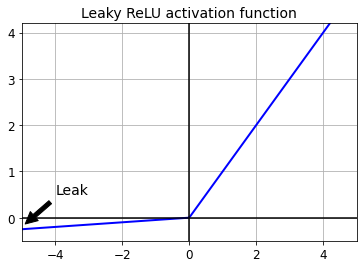

In [10]:
def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha*x, x)

plt.plot(x, leaky_relu(x, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

The hyperparameter $\alpha$ defines how much the function “leaks”: it is the slope of the function for z < 0. This small slope ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up. 

Other variants are: the **randomized leaky ReLU (RReLU)**, where $\alpha$ is picked randomly in a given range during training and is fixed to an average value during testing, and the **parametric leaky ReLU (PReLU)**, where $\alpha$ is authorized to be learned during training. For a comparison of several variants of the ReLU activation function, we can refer to the paper:[Bing Xu et al. **Empirical Evaluation of Rectified Activations in Convolutional Network** arXiv preprint arXiv:1505.00853 (2015)](https://arxiv.org/pdf/1505.00853.pdf)

In Keras, to use the leaky ReLU activation function, we can just create a LeakyReLU layer and add it to our model just after the layer we want to apply it to.

Another possibility is to use the **exponential linear unit (ELU)** activation function, that outperform ReLU variants: 

$\text{ELU}_\alpha(x) = 
\begin{cases}
    \alpha(\text{exp}(x)-1 & \text{if} & x \lt 0 \\
     x & \text{if} & x \gt 0
\end{cases}$




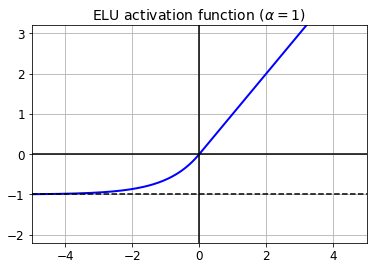

In [11]:
def elu(x, alpha=1):
    return np.where(x < 0, alpha * (np.exp(x) - 1), x)

plt.plot(x, elu(x), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

The main drawback of the ELU activation function is that it is slower to compute than the ReLU functions (due to the use of the exponential function). Its faster convergence rate during training compensates for that slow computation, but still, at test time an ELU network will be slower than a ReLU network.

Finally, the **Scaled ELU (SELU)** activation function is a variant of the ELU activation function. For a neural network composed exclusively of a stack of dense layers, the SELU activation function allows a self-normalization:
the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, which solves the vanishing/exploding gradients problem. As a result, the SELU activation function often significantly outperforms other activation functions for such neural nets.

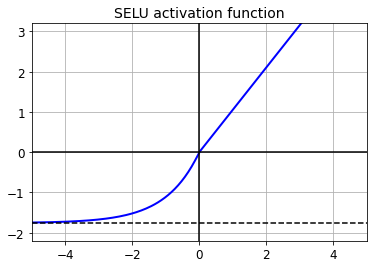

In [12]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

def selu(x, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(x, alpha)

plt.plot(x, selu(x), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

So, which activation function should we use? In general SELU -> ELU -> leaky ReLU (and its variants) -> ReLU -> tanh > logistic. However, because ReLU is the most used activation function, many libraries and hardware accelerators provide ReLU-specific optimizations; therefore, if speed is a priority, ReLU might  be the best choice.

An update list of activation functions with refereces can be accessed [here](https://paperswithcode.com/methods/category/activation-functions)

Let's train a neural network on Fashion MNIST using different activation functions.

**1) Leaky ReLU**

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [12]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.2934 - accuracy: 0.5906 - val_loss: 0.8794 - val_accuracy: 0.7226
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7985 - accuracy: 0.7396 - val_loss: 0.7106 - val_accuracy: 0.7720
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6858 - accuracy: 0.7737 - val_loss: 0.6366 - val_accuracy: 0.7956
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6263 - accuracy: 0.7918 - val_loss: 0.5925 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5877 - accuracy: 0.8037 - val_loss: 0.5637 - val_accuracy: 0.8140
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5605 - accuracy: 0.8126 - val_loss: 0.5383 - val_accuracy: 0.8220
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5395 - accuracy: 0.8186 - val_loss: 0.5243 - val_accuracy:

**2) Leaky PReLU**

In [13]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [15]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.3676 - accuracy: 0.5957 - val_loss: 0.9001 - val_accuracy: 0.7254
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8055 - accuracy: 0.7416 - val_loss: 0.7121 - val_accuracy: 0.7720
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6886 - accuracy: 0.7728 - val_loss: 0.6371 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6294 - accuracy: 0.7904 - val_loss: 0.5925 - val_accuracy: 0.8070
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5906 - accuracy: 0.8035 - val_loss: 0.5596 - val_accuracy: 0.8144
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5625 - accuracy: 0.8117 - val_loss: 0.5358 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5409 - accuracy: 0.8180 - val_loss: 0.5185 - val_accuracy:

**3) SELU (with 100 hidden layers)**

In [20]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [18]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [19]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [21]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 13s 8ms/step - loss: 1.2919 - accuracy: 0.5059 - val_loss: 0.9045 - val_accuracy: 0.6812
Epoch 2/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.9088 - accuracy: 0.6622 - val_loss: 0.7168 - val_accuracy: 0.7502
Epoch 3/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.6925 - accuracy: 0.7489 - val_loss: 0.7484 - val_accuracy: 0.7152
Epoch 4/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.6030 - accuracy: 0.7850 - val_loss: 0.5741 - val_accuracy: 0.8050
Epoch 5/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5305 - accuracy: 0.8142 - val_loss: 0.5149 - val_accuracy: 0.8294


Now look at what happens if we try to use the ReLU activation function with 100 hidden layers:

In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [23]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [24]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 12s 7ms/step - loss: 2.1582 - accuracy: 0.1884 - val_loss: 1.8396 - val_accuracy: 0.2968
Epoch 2/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.6136 - accuracy: 0.3405 - val_loss: 1.2495 - val_accuracy: 0.4862
Epoch 3/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.1963 - accuracy: 0.4847 - val_loss: 1.0074 - val_accuracy: 0.5718
Epoch 4/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.9312 - accuracy: 0.6046 - val_loss: 0.9630 - val_accuracy: 0.6234
Epoch 5/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8274 - accuracy: 0.6680 - val_loss: 0.8217 - val_accuracy: 0.6752


Not great at all, we suffered from the vanishing/exploding gradients problem.

### Batch Normalization

Initialization techniques andELU (or variant of ReLU) can significantly reduce the the vanishing/exploding gradients problems at the beginning of training, however it doesn’t guarantee that they won’t come back during training.
**Batch Normalization** (BN) technique consists of adding an operation in the model before or after the activation function of each hidden layer. This operation **zerocenters and normalizes** each input, then scales and shifts the result using
two new parameters (to be learned during backpropagation). Often, if we add a BN layer as first layer, we do not need to standardize the training set; the BN layer will do it (approximately, since it only looks at one batch at a time).

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and standard deviation of the input over the current mini-batch (hence the name “Batch Normalization”):

$\begin{align}
\mu_{B}=\frac{1}{m_B}\sum\limits_{i=1}^{m_B}{x^{(i)}}
\end{align}$ 

$\begin{align}
\sigma _B^2 =\frac{1}{m_B}\sum\limits_{i=1}^{m_B}{(x^{(i)}-\mu _B)^2}
\end{align}$ 

$\begin{align}
\hat{x}^{(i)} =\frac{x^{(i)}-\mu _B}{\sqrt{\sigma _B^2+\epsilon}} 
\end{align}$

$\begin{align}
z^{(i)}=\gamma \otimes \hat{x}^{(i)}+\beta 
\end{align}$

where:
- $B$ is the mini-batch
- $m_B$ is the number of instances in the mini-batch
- $\mu_{B}$ is the vector of input means, evaluated over the mini-batch
- $\sigma_B$ is the vector of input standard deviations, evaluated over the minibatch
- $\hat{x}^{(i)}$ is the vector of zero-centered and normalized inputs for instance i
- $\gamma$ is the scale parameter vector for the layer
- $\beta$ is the shift parameter vector for the layer
- $\epsilon$ is a tiny number (smoothing term) to avoids division by zero
- $z^{(i)}$ is the output of the BN operation: a rescaled and shifted version of the inputs.

So during training, BN standardizes its inputs, then rescales and offsets
them. But what about at prediction time? We may need to make predictions for individual instances or over small batch of instances, so computing statistics would be unreliable. 

One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer. These “final” input means and standard deviations could then be used instead of the batch ones when making predictions. 

Most implementations of BN (also Keras) estimate these "final" statistics during training by using a moving average of the layer’s input means and standard deviations.

The paper [Sergey Ioffe and Christian Szegedy **Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift** Proceedings of the 32nd International Conference on Machine Learning (2015)](https://arxiv.org/abs/1502.03167) shows tha BN considerably improve DNN, in particular leading to a huge improvement in the [ImageNet](http://www.image-net.org/) classification task. 

BN, however, adds some complexity to the model and there is a runtime penalty: the NN makes slower predictions due to the extra computations required at each layer. Fortunately, it’s  possible to fuse the BN layer with the previous layer, after training, in order to avoid the runtime penalty. This is done by updating the previous layer’s weights and biases so that it directly produces outputs of the appropriate scale and offset. The previous laryer computes: 

$\begin{align}
XW+b
\end{align}$

the BN layers computes (ignoring the smoothing term): 

$\begin{align}
\gamma \otimes \frac{(XW+b-\mu)}{\sigma} + \beta
\end{align}$

If we define:

$\begin{align}
W' = \gamma \otimes \frac{W}{\sigma}
\end{align}$

$\begin{align}
b'= \gamma \otimes \frac{(b-\mu)}{\sigma} +\beta
\end{align}$

the equation simplifies to

$\begin{align}
XW'+b'
\end{align}$

So, if we replace the previous layer’s weights and biases ($W$ and $b$) with the updated weights and biases ($W'$ and $b'$), we can get rid of the BN layer.

In Keras, we can use BN just adding a **BatchNormalization** layer before or after each hidden layer activation function. As an example, the following model applies BN after every hidden layer and as the first layer (after flattening the input images): 

In [4]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In tiny example with just two hidden layers, it’s unlikely that BN will have a positive impact, but for deeper networks it can make a tremendous difference.

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

As we can see, each BN layer adds four parameters per input ($\gamma$, $\beta$, $\mu$, and $\sigma$), the first BN layer adds 3.136 parameters (which is 4x784). The last two parameters ($\mu$, and $\sigma$) are the moving averages and they are not affected by backpropagation, so Keras calls them **non-trainable** (3.136 + 1.200 + 400)/2=2.368

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.8672 - accuracy: 0.7114 - val_loss: 0.5619 - val_accuracy: 0.8130
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5810 - accuracy: 0.8026 - val_loss: 0.4835 - val_accuracy: 0.8356
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5197 - accuracy: 0.8202 - val_loss: 0.4453 - val_accuracy: 0.8460
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4811 - accuracy: 0.8328 - val_loss: 0.4223 - val_accuracy: 0.8506
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4590 - accuracy: 0.8411 - val_loss: 0.4074 - val_accuracy: 0.8568
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4412 - accuracy: 0.8439 - val_loss: 0.3960 - val_accuracy: 0.8606
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4247 - accuracy: 0.8501 - val_loss: 0.3860 - val_accuracy:

Sometimes applying BN before the activation function works better, there's a debate on this topic:

In [4]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 1.0439 - accuracy: 0.6797 - val_loss: 0.6768 - val_accuracy: 0.7884
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6844 - accuracy: 0.7812 - val_loss: 0.5584 - val_accuracy: 0.8158
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5949 - accuracy: 0.8039 - val_loss: 0.5024 - val_accuracy: 0.8320
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5458 - accuracy: 0.8173 - val_loss: 0.4678 - val_accuracy: 0.8424
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5151 - accuracy: 0.8262 - val_loss: 0.4441 - val_accuracy: 0.8496
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4920 - accuracy: 0.8335 - val_loss: 0.4271 - val_accuracy: 0.8554
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4720 - accuracy: 0.8397 - val_loss: 0.4136 - val_accuracy:

BN has become one of the most-used layers in DNN, to the point that it is often omitted in the diagrams, as it is assumed that BN is added after every layer. However, a recent paper [Hongyi Zhang et al. **Fixup Initialization: Residual Learning Without Normalization** arXiv preprint arXiv:1901.09321 (2019)](https://arxiv.org/abs/1901.09321) may change this assumption: by using a novel weight initialization technique, the authors managed to train a very deep NN (10,000 layers!) without BN, achieving state-of-the-art performance on complex image classification tasks.

### Gradient Clipping

Another popular technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold. This technique, called **Gradient Clipping**, was presented in the paper [Razvan Pascanu et al. **On the Difficulty of Training Recurrent Neural Networks** Proceedings of the 30th International Conference on Machine Learning (2013)](https://arxiv.org/abs/1211.5063) and it is most often used in recurrent neural networks, for other types of networks, BN is usually sufficient.

In Keras, the use of Gradient Clipping is done by setting **clipvalue** or **clipnorm** arguments when creating an optimizer:

In [5]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="mse", optimizer=optimizer)

This optimizer will clip every component of the gradient vector to a value between –1.0 and 1.0. Note that this may change the orientation of the gradient vector. For instance, if the
original gradient vector is [0.9, 100.0], it points mostly in the direction of the second axis; but once you clip it by value, you get [0.9, 1.0], which points roughly in the diagonal between the two axes. In practice, this approach works well. If we want to ensure that Gradient Clipping does not change the direction of the gradient vector, we can clip by norm by setting clipnorm instead of clipvalue. This will clip the whole gradient if its norm is greater than the threshold.

## Transfer Learning

It is generally not a good idea to train a large DNN from scratch: instead, we can try to find an existing neural network that accomplishes a similar task to the one we are trying to tackle, then reuse the lower layers of this network. This technique is called **transfer learning**. It will not only speedcup training considerably, but also require significantly less training data.

Suppose we have access to a DNN that was trained to classify pictures into 100 different categories (e.g. animals, plants, vehicles, and everyday objects) and we want to train a DNN to classify specific types of vehicles. These tasks are very similar, even partly overlapping, so we can try to reuse parts of the first network.

<img src="transfer-learning.png" width="500">

The output layer of the original model should usually be replaced because it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task. Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. We have  to find the right number of layers to reuse: the more similar the tasks are, the more layers we can reuse (starting with the lower layers). For very similar tasks, we can try to keep all the hidden layers and just replace the output layer.

Let's look at a simple example in order to show how Transfer Learning can be implemented in Keras. Suppose someone has built a model on a simpler Fashion MNIST dataset (one with only eight classes, all the classes except for sandal and shirt). Let’s call this model A. We now want to tackle a different task: we have images of sandals and shirts, and we want to train a binary classifier (positive=shirt, negative=sandal). That task is quite similar to the first one, so we can try transfer learning.

Let's split the fashion MNIST training set in two:
- X_train_A: all images of all items except for sandals and shirts (classes 5 and 6)
- X_train_B: a much smaller training set of just the first 200 images of sandals or shirts

In [6]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [7]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [8]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 1s 980us/step - loss: 0.5599 - accuracy: 0.8162 - val_loss: 0.3792 - val_accuracy: 0.8647
Epoch 2/20
1375/1375 [==============================] - 1s 899us/step - loss: 0.3522 - accuracy: 0.8772 - val_loss: 0.3220 - val_accuracy: 0.8869
Epoch 3/20
1375/1375 [==============================] - 1s 904us/step - loss: 0.3161 - accuracy: 0.8896 - val_loss: 0.3056 - val_accuracy: 0.8924
Epoch 4/20
1375/1375 [==============================] - 1s 886us/step - loss: 0.2967 - accuracy: 0.8967 - val_loss: 0.2859 - val_accuracy: 0.8996
Epoch 5/20
1375/1375 [==============================] - 1s 892us/step - loss: 0.2841 - accuracy: 0.9012 - val_loss: 0.2817 - val_accuracy: 0.9028
Epoch 6/20
1375/1375 [==============================] - 1s 923us/step - loss: 0.2740 - accuracy: 0.9057 - val_loss: 0.2692 - val_accuracy: 0.9058
Epoch 7/20
1375/1375 [==============================] - 1s 890us/step - loss: 0.2665 - accuracy: 0.9090 - val_loss: 0.2656 -

Now we create a new model (model B) based on that model A layers, let’s reuse all the layers except for the output layer. We can train model B for task B, but since the new output layer was initialized randomly, it will make large errors, so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, we have to set every layer’s trainable attribute to false, compile the model and train it for a few epochs; then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B.

In [10]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B = keras.models.Sequential(model_A_clone.layers[:-1])
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

for layer in model_B.layers[:-1]:
    layer.trainable = False

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=4,
                      validation_data=(X_valid_B, y_valid_B))

for layer in model_B.layers[:-1]:
    layer.trainable = True

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=16,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 18ms/step - loss: 1.2335 - accuracy: 0.2200 - val_loss: 1.1227 - val_accuracy: 0.2617
Epoch 2/4
7/7 [==============================] - 0s 5ms/step - loss: 1.1146 - accuracy: 0.2450 - val_loss: 1.0182 - val_accuracy: 0.3103
Epoch 3/4
7/7 [==============================] - 0s 5ms/step - loss: 1.0087 - accuracy: 0.3000 - val_loss: 0.9248 - val_accuracy: 0.3580
Epoch 4/4
7/7 [==============================] - 0s 5ms/step - loss: 0.9144 - accuracy: 0.3750 - val_loss: 0.8416 - val_accuracy: 0.4199
Epoch 1/16
7/7 [==============================] - 0s 17ms/step - loss: 0.7006 - accuracy: 0.5600 - val_loss: 0.5144 - val_accuracy: 0.7323
Epoch 2/16
7/7 [==============================] - 0s 5ms/step - loss: 0.4434 - accuracy: 0.8300 - val_loss: 0.3640 - val_accuracy: 0.8773
Epoch 3/16
7/7 [==============================] - 0s 5ms/step - loss: 0.3171 - accuracy: 0.8950 - val_loss: 0.2824 - val_accuracy: 0.9249
Epoch 4/16
7/7 [====================

So, what’s the final verdict? We can compare with a network learned from scratch:

In [11]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 0.8604 - accuracy: 0.4950 - val_loss: 0.7212 - val_accuracy: 0.5781
Epoch 2/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6356 - accuracy: 0.6300 - val_loss: 0.5620 - val_accuracy: 0.6937
Epoch 3/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4898 - accuracy: 0.7600 - val_loss: 0.4558 - val_accuracy: 0.8022
Epoch 4/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3944 - accuracy: 0.8650 - val_loss: 0.3824 - val_accuracy: 0.8621
Epoch 5/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3271 - accuracy: 0.8900 - val_loss: 0.3303 - val_accuracy: 0.8895
Epoch 6/20
7/7 [==============================] - 0s 5ms/step - loss: 0.2788 - accuracy: 0.9200 - val_loss: 0.2899 - val_accuracy: 0.9189
Epoch 7/20
7/7 [==============================] - 0s 5ms/step - loss: 0.2422 - accuracy: 0.9350 - val_loss: 0.2607 - val_accuracy: 0.9290
Epoch 8/20
7/7 [=================

If you try to change the classes or the random seed, you will see that the improvement generally drops, or even vanishes or reverses.

It turns out that transfer learning does not work very well with small dense networks, presumably because small networks learn few patterns, and dense networks learn very specific patterns, which are unlikely to be useful in other tasks. Transfer learning works best with deep convolutional neural networks, which tend to learn feature detectors that are much more general (especially in the lower layers). 

## Faster Optimization

Training large DNNs can be painfully slow. A huge speed boost comes from using a
faster optimizer than the regular Gradient Descent optimizer. In this section we will present the most popular algorithms: momentum optimization, Nesterov Accelerated Gradient, AdaGrad, RMSProp, and finally Adam and Nadam optimization.

### Momentum Optimization

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity. In contrast, regular Gradient Descent will simply take small, regular steps down the slope, so the algorithm will take much more time to reach the bottom.

Recall that Gradient Descent updates the weights by subtracting the gradient of the cost function with regard to the weight multiplied by the learning rate:

$\theta = \theta - \eta \nabla J(\theta)$

It does not care about what the earlier gradients were. If the local gradient is tiny, it goes very slowly.

Momentum optimization ([Boris T. Polyak **Some Methods of Speeding Up the Convergence of Iteration Methods** USSR Computational Mathematics and Mathematical Physics 4, no. 5 (1964)](https://vsokolov.org/courses/750/files/polyak64.pdf)) cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient from the momentum vector $m$ and it updates the weights by adding this momentum:

$m = \beta m - \eta \nabla J(\theta)$

$\theta = \theta + m$

In other words, the gradient is **used for acceleration, not for speed**. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter $\beta$, called the **momentum**, which must be set between 0 (high friction) and 1 (no friction). A typicalvmomentum value is 0.9.

In order to use momentum optimization in Keras, we have to use the SGD optimizer and set its **momentum hyperparameter**:

In [12]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

### Nesterov Accelerated Gradient

The **Nesterov Accelerated Gradient (NAG**) method ([Yurii Nesterov **A Method for Unconstrained Convex Minimization Problem with the Rate of Convergence** Doklady AN USSR 269 (1983)](http://mpawankumar.info/teaching/cdt-big-data/nesterov83.pdf)), is a small variant to momentum optimization which measures the gradient of the cost function not at the local position but slightly ahead in the direction of the momentum, at:

$m = \beta m - \eta \nabla J(\theta + \beta m)$

$\theta = \theta + m$

This small tweak works because in general the momentum vector will be pointing in the right direction (toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position:  

<img src="nesterov.png" width="500">


To use it, simply set **nesterov=True** when creating the SGD optimizer:

In [13]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

### AdaGrad

Consider the elongated bowl problem again: Gradient Descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum. The **AdaGrad algorithm** [John Duchi et al. **Adaptive Subgradient Methods for Online Learning and Stochastic Optimization** Journal of Machine Learning Research 12 (2011)](https://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf) achieves this correction by scaling down the gradient vector along the
steepest dimensions:





